# Depth Prediction Example with GA-Net

In [1]:
import sys
import os
cwd = os.getcwd()
wd = os.path.join(cwd, "ganet")
sys.path.append(wd)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.utils.data as data
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from PIL import Image
from models.GANet_deep import GANet

In [3]:
model_name = "ganet"
max_disp = 192

### Load model from checkpoint
It seems that the model pretrained with multiple GPUs since it needs nn.DataParallel to properly load the pretrained model. Therefore, as least 1 GPU is required to run this demo

In [4]:
model = GANet(max_disp)
model = nn.DataParallel(model).cuda()

In [5]:
checkpt_path = os.path.join(wd, "checkpts", "kitti2015_final.pth")
checkpt = torch.load(checkpt_path)
model.load_state_dict(checkpt['state_dict'])
print("Loaded pretrained model")

Loaded pretrained model


### Predict depth from input images

GA-Net needs a differetn dataset class to crop the images first. Cropping is done so that the input images agree with the model design.

In [6]:
class DepthEstDataset(data.Dataset):
    def __init__(self, model_name):
        super(DepthEstDataset, self).__init__()
        data_path = "imgs/"
        self.left_im_path = os.path.join(data_path, "left")
        self.right_im_path = os.path.join(data_path, "right")
        self.pred_depth_path = os.path.join(data_path, "pred_depth", model_name)
        if not os.path.exists(self.pred_depth_path):
            os.makedirs(self.pred_depth_path)
        self.data_list = os.listdir(self.left_im_path)
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, item):
        file_name = self.data_list[item]        
        left_im = Image.open(os.path.join(self.left_im_path, file_name))
        right_im = Image.open(os.path.join(self.right_im_path, file_name))
        left_im = np.asarray(left_im)
        right_im = np.asarray(right_im)
        left_im = left_im[:, 0:624, :]
        right_im = right_im[:, 0:624, :]
        left_im = self.to_tensor(left_im)
        right_im = self.to_tensor(right_im)

        depth_filename = file_name.split('.')[0] + ".npy"
        pred_depth_filename = os.path.join(self.pred_depth_path,
                                           depth_filename)  # path to save the predicted depth file as a np array
        return left_im, right_im, pred_depth_filename

In [7]:
depth_dataset = DepthEstDataset(model_name)
test_loader = DataLoader(depth_dataset, batch_size=1, shuffle=True)

In [8]:
model.eval()
with torch.no_grad():
    for batch_id, inputs in enumerate(test_loader):
        left_im, right_im, pred_disp_path = inputs
        left_im = left_im.cuda()
        right_im = right_im.cuda()
        left_im = left_im[:,:,0:624]
        right_im = right_im[:,:,0:624]
        outputs = model(left_im, right_im)
        pred_disp = outputs.detach().cpu().numpy()
        pred_disp = np.squeeze(pred_disp)
        
        np.save(pred_disp_path[0], pred_disp)

/home/xfan/Applications/anaconda3/envs/cv/lib/python3.7/site-packages/torchvision/transforms/functional.py:74: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


### Print a sample image and its predicted depth

In [9]:
left_im = torch.squeeze(left_im)
left_im = left_im.detach().cpu()
left_im = transforms.ToPILImage()(left_im)

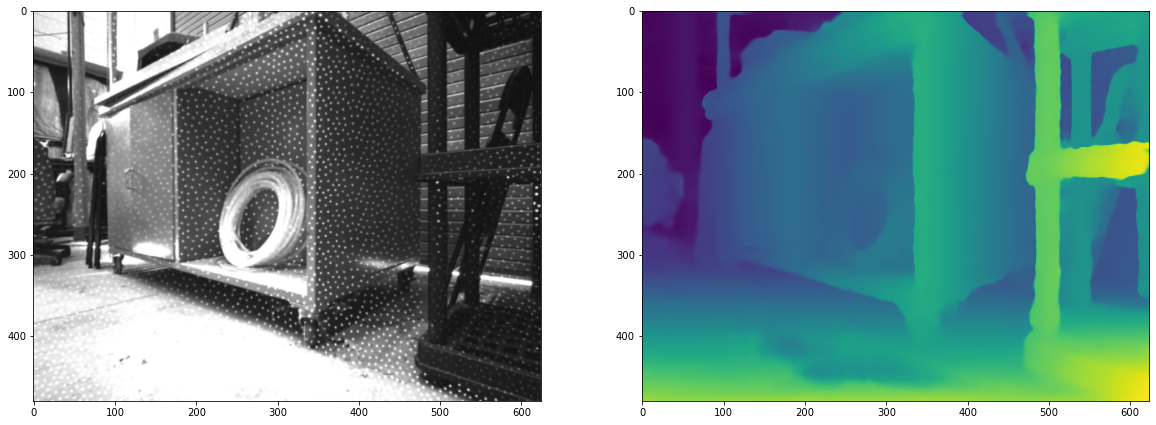

In [10]:
%matplotlib inline
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(left_im)
plt.subplot(122)

pred_disp_for_plot = np.copy(pred_disp)
pred_disp_for_plot[pred_disp_for_plot>max_disp] = 0  # remove some outliers
pred_disp_for_plot = pred_disp_for_plot / np.amax(pred_disp_for_plot)
plt.imshow(pred_disp_for_plot)